# Technical Portfolio Analyzer

This Jupyter Notebook will outline the exploration, developement and clean-up of the appliation code

### Table of Contents
- Data connectors
- Data query and clean-up
- Analytical methods
    - Technical
    - Fundamental
    - Traditional
- Visualization
- Dashboard (GUI)
    - GUI
    - Data filtration methods

### Dependencies

In [2]:
# Data analytics
import pandas as pd
import numpy as np
import panel as pn
import bs4 as bs

# Visualization
pn.extension('plotly')
import plotly.express as px
import hvplot.pandas
import matplotlib.pyplot as plt

# System
import os
import time
from pathlib import Path
from dotenv import load_dotenv
import requests

# Finance
import alpaca_trade_api as tradeapi

import warnings
warnings.filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
/Users/nfroemm/Code/anaconda3/envs/pyvis-py37-try2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Traditional Portfolio Analysis

In [3]:
plt.style.use('~/.matplotlib/matplotlibrc-save')

In [4]:
# Automatically re-import the python module(s) you're working on
%load_ext autoreload
%autoreload 1
%aimport MyPortfolioSimulator

In [5]:
from MyPortfolioSimulator import get_tickers
from MyPortfolioSimulator import get_attributes
from MyPortfolioSimulator import get_log_returns
from MyPortfolioSimulator import get_sharpe_ratios
from MyPortfolioSimulator import MyPortfolioSimulator
from MyPortfolioSimulator import PortfolioOptimizationResult

In [6]:
# Please start with calculating the Sharpe Ratio Calculation
# Your method must take entire dataframe and return a dataframe with ticker and sharpe ratio for the given time
# Please keep in mind that the dataframe will contain multiple tickers
# Follow specs for method writing outlined below, feel free to expand and improve
# Document your method with docstring
# Document theory for your method in readme (see the README.md for example)

# Method test

### Notes To Myself

#### Logarithmic vs. Fractional Returns

Fractional rate of return of a time series $\{S_t\}_{t=1}^{T}$: 

\begin{equation}
    r^\text{(frac)}_t  \equiv  \frac{S_{t} - S_{t-1}}{S_{t-1}}    \qquad\Longleftrightarrow\qquad
    S_{t}  =  \left( 1  +  r^\text{(frac)}_t \right) S_{t-1}
\end{equation}

Logarithmic rate of return of a time series $\{S_t\}_{t=1}^{T}$: 

\begin{equation}
    r^\text{(log)}_t  \equiv  \ln(S_{t})  -  \ln(S_{t-1})  =  \ln\left( \frac{S_{t}}{S_{t-1}} \right)    \qquad\Longleftrightarrow\qquad
    S_{t}  =  \exp\left( r^\text{(log)}_t \right)  S_{t-1}  
\end{equation}

The formulas for converting back and forth between fractional and logarithmic returns are 

\begin{equation}
    r^\text{(log)}_t  =  \ln\left( \frac{S_{t}}{S_{t-1}} \right)
        =  \ln\left( 1  +  \frac{S_{t} - S_{t-1}}{S_{t-1}} \right)
        =  \ln\left( 1  +  r^\text{(frac)}_t \right)
    \qquad\Longleftrightarrow\qquad
    r^\text{(frac)}_t  =  \exp\left( r^\text{(log)}_t \right)  -  1
\end{equation}

By letting $t \to t-1$ in the above formulas, you get the usual "cumulative product" formulas.  


#### Portfolio Optimization

Expected Portfolio Return: 

\begin{equation}
    \mu_{p}  \equiv  \omega_1 \mu_1  +  \omega_2 \mu_2  +  \cdots  +  \omega_N \mu_N  =  \sum_{i=1}^{N} \omega_i \mu_i  \equiv  \boldsymbol{\omega} \cdot \boldsymbol{\mu}
\end{equation}


Expected Portfolio Variance: 

\begin{equation}
    \Sigma_{p}  =  \boldsymbol{\omega} \cdot \boldsymbol{\Sigma} \cdot \boldsymbol{\omega}  \equiv  \sigma_{p}^2
\end{equation}

In [7]:
price_data_path = Path('resources/price_data.csv')
df_alpaca_ohlcv = pd.read_csv(price_data_path, header=[0, 1], index_col=0)
df_alpaca_ohlcv.head()

A                                  AAL  \
                            open   high    low  close   volume   open   
time                                                                    
2020-01-02 05:00:00+00:00  85.90  86.35  85.20  85.95  1199810  28.98   
2020-01-03 05:00:00+00:00  84.67  85.33  84.50  84.53   895182  28.27   
2020-01-06 05:00:00+00:00  84.00  84.82  83.60  84.78  1380173  27.19   
2020-01-07 05:00:00+00:00  83.96  85.26  83.94  85.09  1192756  27.56   
2020-01-08 05:00:00+00:00  85.96  86.47  85.20  85.91  1453322  27.21   

                                                            ...   ZION  \
                              high    low  close    volume  ...   open   
time                                                        ...          
2020-01-02 05:00:00+00:00  29.2950  28.65  29.09   5292996  ...  52.36   
2020-01-03 05:00:00+00:00  28.2900  27.34  27.65  13006571  ...  51.41   
2020-01-06 05:00:00+00:00  27.4901  27.08  27.32   5383583  ...  51.08   
2020-01-07 05:00:00+00:00  27.6800  27.06  27.22   5570129  ...  50.79   
2020-01-08 05:00:00+00:00  28.0900  27.10  27.84   9479470  ...  50.90   

                                                              ZTS           \
                             high     low  close   volume    open     high   
time                                                                         
2020-01-02 05:00:00+00:00  52.480  51.790  52.44  1307412  132.05  134.280   
2020-01-03 05:00:00+00:00  51.890  51.160  51.70  1012303  132.48  134.910   
2020-01-06 05:00:00+00:00  51.680  50.805  51.07  1048073  133.78  134.065   
2020-01-07 05:00:00+00:00  51.125  50.610  50.74  1223552  133.00  134.810   
2020-01-08 05:00:00+00:00  51.490  50.630  51.26  2096814  133.76  135.270   

                                                     
                              low    close   volume  
time                                                 
2020-01-02 05:00:00+00:00  131.48  134.150  1308668  
2020-01-03 05:00:00+00:00  132.27  134.110  1038786  
2020-01-06 05:00:00+00:00  132.71  133.100  1259478  
2020-01-07 05:00:00+00:00  132.67  133.600  1047293  
2020-01-08 05:00:00+00:00  133.24  133.325  1379814  

[5 rows x 2525 columns]

In [8]:
debug = True

# Cache list of stock tickers and attributes (@Alpaca)
tickers = get_tickers(df_alpaca_ohlcv)
attributes = get_attributes(df_alpaca_ohlcv) 
if debug:
    print(f"tickers:\n{tickers}")
    print()
    print(f"attributes:\n{attributes}")
    print()

tickers:
['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATVI', 'AWK', 'AXP', 'GOOG', 'GOOGL', 'LNT', 'MMM', 'MO', 'ADP', 'ADSK', 'AIZ', 'AJG', 'ATO', 'AVB', 'AVGO', 'AVY', 'AZO', 'BA', 'BAC', 'BAX', 'BBY', 'BDX', 'BF.B', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLK', 'BLL', 'BMY', 'BR', 'BRK.B', 'BSX', 'BWA', 'BXP', 'CAH', 'CARR', 'CAT', 'CBOE', 'CBRE', 'CCL', 'CDNS', 'CDW', 'CE', 'CERN', 'CF', 'CHRW', 'CNC', 'CNP', 'COF', 'COG', 'CPB', 'CTLT', 'CZR', 'KMX', 'SCHW', 'T', 'C', 'CAG', 'CB', 'CCI', 'CFG', 'CHD', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'COO', 'COP', 'COST', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTVA', 'CTXS', 'CVS', 'CVX', 'DAL', 'DE', 'DFS', 'DG', 'DHI', 'DHR', 'DISCA', 'DISCK'

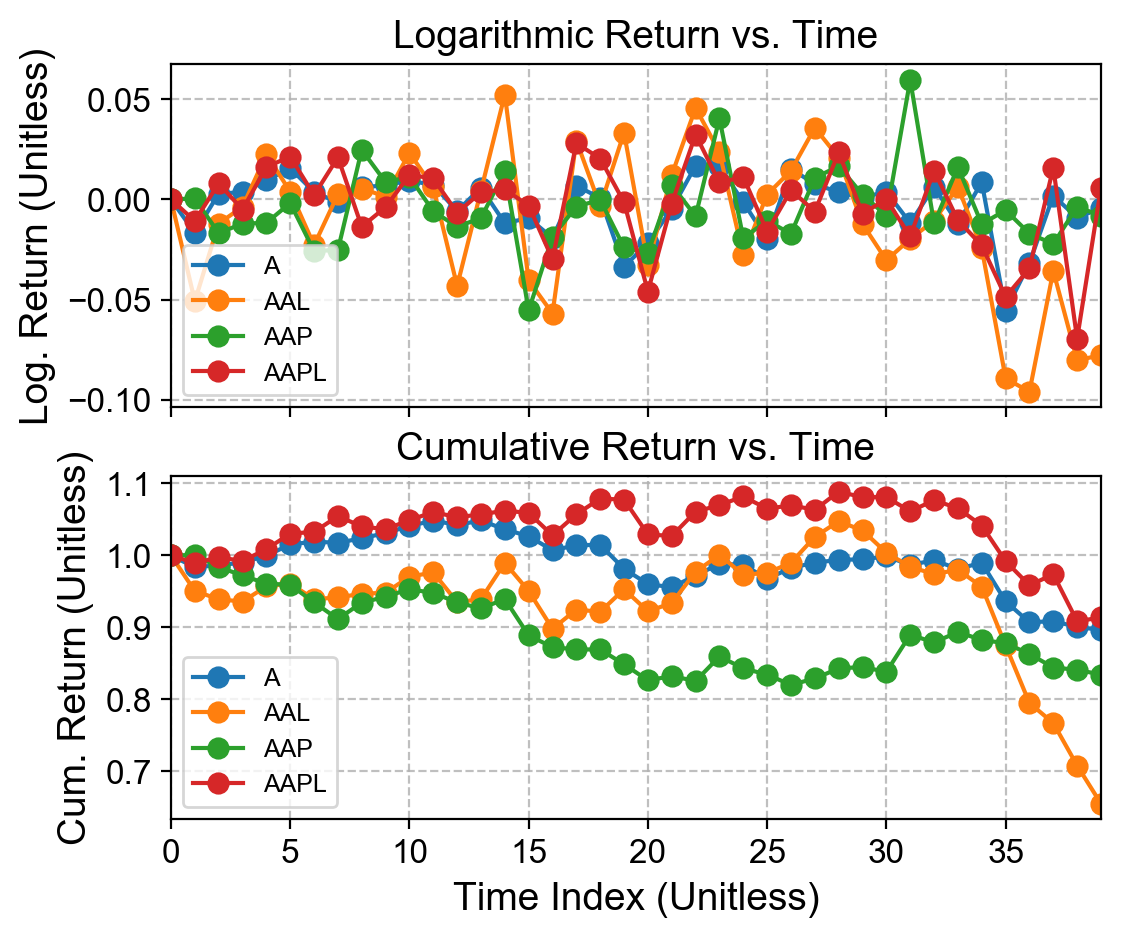

In [19]:
# Calculate logarithmic returns
df_log_returns = get_log_returns(df_alpaca_ohlcv)
df_log_returns = df_log_returns.droplevel(1, axis=1)

df_cum_returns = np.exp(df_log_returns.iloc[:, :4]).cumprod()

fig, axs = plt.subplots(nrows=2, figsize=(6, 5), sharex=True)
plot_kwargs = dict(style='o-', use_index=False)
ax = axs[0]
df_log_returns.iloc[:, :4].plot(ax=ax, **plot_kwargs)
ax.set_title('Logarithmic Return vs. Time')
ax.set_xlabel('Time Index (Unitless)')
ax.set_ylabel('Log. Return (Unitless)')
ax = axs[1]
df_cum_returns.plot(ax=ax, **plot_kwargs)
ax.set_title('Cumulative Return vs. Time')
ax.set_xlabel('Time Index (Unitless)')
ax.set_ylabel('Cum. Return (Unitless)')
plt.show()

In [10]:
# Get annualized Sharpe Ratios
df_sharpe_ratios = get_sharpe_ratios(df_alpaca_ohlcv)
df_sharpe_ratios

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WY,WYNN,XEL,XLNX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
,sharpe_ratio,sharpe_ratio,sharpe_ratio,sharpe_ratio,sharpe_ratio,sharpe_ratio,sharpe_ratio,sharpe_ratio,sharpe_ratio,sharpe_ratio,...,sharpe_ratio,sharpe_ratio,sharpe_ratio,sharpe_ratio,sharpe_ratio,sharpe_ratio,sharpe_ratio,sharpe_ratio,sharpe_ratio,sharpe_ratio
0,-2.883711,-4.640745,-3.656721,-1.669808,-0.986409,-0.172349,-1.390856,-3.395786,-4.069941,0.848332,...,-2.678038,-3.98514,-0.009815,-2.878832,-0.669066,-3.492697,-2.317577,-3.888916,-6.452427,-0.213645


In [13]:
# Here's how to sort the Sharpe-Ratio data and select the `nbest`
nbest = 10
df_sharpe_ratios.squeeze().sort_values(ascending=True).dropna()[-nbest:]

BLL   sharpe_ratio    2.237162
MSCI  sharpe_ratio    2.292934
LB    sharpe_ratio    2.450727
TMUS  sharpe_ratio    2.470889
REGN  sharpe_ratio    2.738794
TSLA  sharpe_ratio    2.759089
ENPH  sharpe_ratio    3.014140
ETSY  sharpe_ratio    3.533336
DXCM  sharpe_ratio    3.587711
ROL   sharpe_ratio    3.636957
Name: 0, dtype: float64

In [43]:
# Define an instance of our portfolio-optimization class
my_sim = MyPortfolioSimulator(
    df_alpaca_ohlcv,
    keep_best_sharpe_ratios = 8,
    allow_shorts = False,
    periods_per_annum = 252,
    debug = False
)

# Example: Get the Equal-Weight Portfolio
equal_weight_portfolio = my_sim.get_equal_weight_portfolio()

# Example: Get the Minimum-Variance Portfolio (numerical solution)
minimum_variance_portfolio = my_sim.get_minimum_variance_portfolio()

# Example: Get the Minimum-Variance Portfolio (analytical solution)
minimum_variance_portfolio_analytical = my_sim.get_minimum_variance_portfolio_analytical()

# Example: Get the Maximum-Sharpe-Ratio Portfolio
maximum_sharpe_ratio_portfolio = my_sim.get_maximum_sharpe_ratio_portfolio()

# Print results
if 0:
    print(equal_weight_portfolio)
    print()
    print(minimum_variance_portfolio_analytical)
    print()
    print(minimum_variance_portfolio)
    print()
    print(maximum_sharpe_ratio_portfolio)
    print()

# Get the "bulk" of the mean-variance plot
my_sim_results = my_sim.get_mean_variance_bulk(num_simulations=100)

# Get the efficient frontier
efficient_frontier = my_sim.get_efficient_frontier()
#for portfolio in efficient_frontier: print(portfolio)

target_return: 0.7410472062082034
target_return: 0.7581436017000247
target_return: 0.775239997191846
target_return: 0.7923363926836673
target_return: 0.8094327881754887
target_return: 0.82652918366731
target_return: 0.8436255791591313
target_return: 0.8607219746509526
target_return: 0.8778183701427739
target_return: 0.8949147656345952
target_return: 0.9120111611264164
target_return: 0.9291075566182379
target_return: 0.9462039521100593
target_return: 0.9633003476018805
target_return: 0.9803967430937018
target_return: 0.9974931385855231
target_return: 1.0145895340773445
target_return: 1.0316859295691658
target_return: 1.0487823250609871
target_return: 1.0658787205528084
target_return: 1.0829751160446297
target_return: 1.100071511536451
target_return: 1.1171679070282723
target_return: 1.1342643025200936
target_return: 1.1513606980119149
target_return: 1.1684570935037362
target_return: 1.1855534889955575
target_return: 1.2026498844873788
target_return: 1.2197462799792
target_return: 1.2368

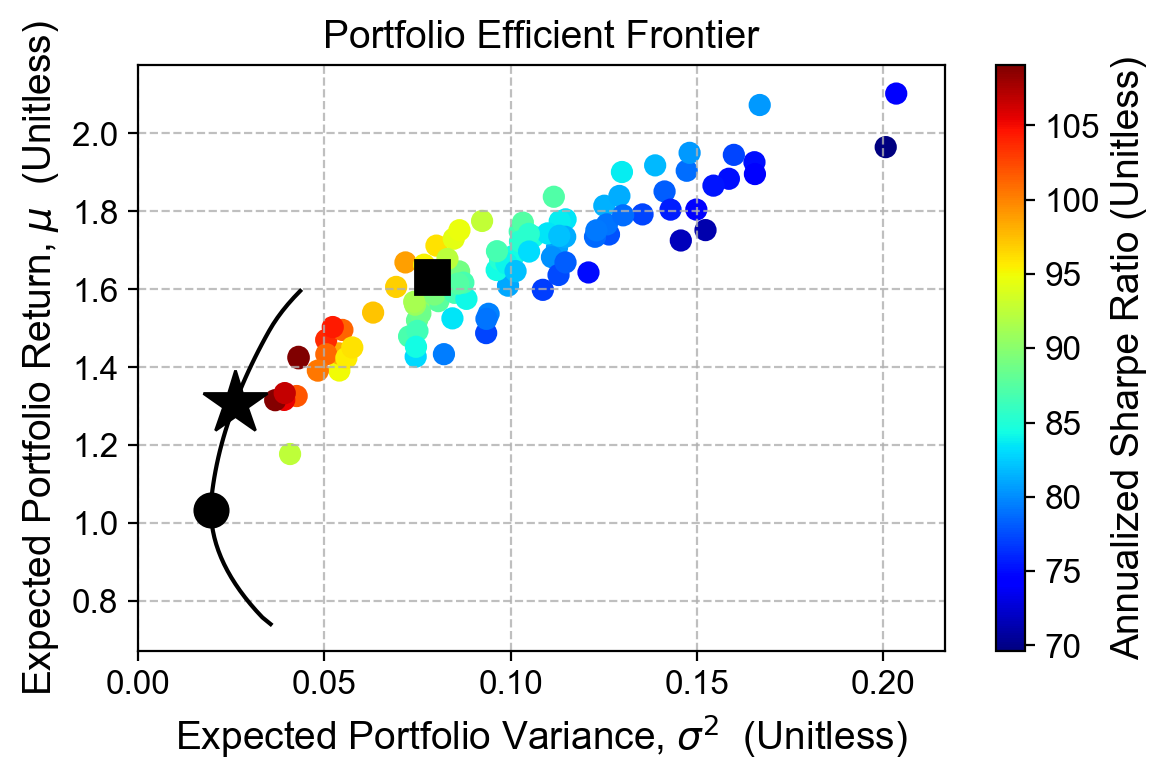

In [45]:
nsims = len(my_sim_results)
xvals = np.array([my_sim_results[i].expected_variance for i in range(nsims)])
yvals = np.array([my_sim_results[i].expected_return for i in range(nsims)])
cvals = np.array([my_sim_results[i].sharpe_ratio for i in range(nsims)])
#xvals = np.sqrt(xvals)

nsims = len(efficient_frontier)
xvals_ef = np.array([efficient_frontier[i].expected_variance for i in range(nsims)])
yvals_ef = np.array([efficient_frontier[i].expected_return for i in range(nsims)])

xmin = min(xvals)
ymin = min(yvals)
xmax = max(xvals)
ymax = max(yvals)
dx = xmax - xmin
dy = ymax - ymin

fig, ax = plt.subplots()
sc = ax.scatter(xvals, yvals, c=cvals, cmap=plt.cm.jet)
border_pad = 0.2
#ax.set_xlim(xmin - (border_pad * dx), xmax + (border_pad * dx))
#ax.set_ylim(ymin - (border_pad * dy), ymax + (border_pad * dy))
ax.set_xlabel('Expected Portfolio Variance, $\sigma^2$  (Unitless)')
ax.set_ylabel('Expected Portfolio Return, $\mu$  (Unitless)')
ax.set_title('Portfolio Efficient Frontier')
ax.plot([minimum_variance_portfolio.expected_variance], [minimum_variance_portfolio.expected_return], 'o', ms=12, color='k')
ax.plot([equal_weight_portfolio.expected_variance], [equal_weight_portfolio.expected_return], 's', ms=12, color='k')
ax.plot([maximum_sharpe_ratio_portfolio.expected_variance], [maximum_sharpe_ratio_portfolio.expected_return], '*', ms=24, color='k')
ax.plot(xvals_ef, yvals_ef, '-', c='k')
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('Annualized Sharpe Ratio (Unitless)')
ax.set_xlim(0.0, )
#ax.set_ylim(0.0, )
plt.tight_layout()
plt.show()

## Visualization

### Notes To Myself

- Left Plot: Returns vs. Time
- Right plot: Efficient Frontier
- Radio Button: Turn on/off {Minimum-Variance, Maximum-Sharpe, Equal-Weight} Portfolios
- Another plot: Distribution of returns?

In [16]:
import holoviews as hv  # needed for adding 'overlays', e.g. efficient-frontier line on top of scatter plot
#import seaborn as sns

### Holoviews

In [73]:
percent = 0.01

nsims = len(my_sim_results)
expected_variance = np.array([my_sim_results[i].expected_variance for i in range(nsims)])
expected_return = np.array([my_sim_results[i].expected_return for i in range(nsims)])
sharpe_ratio = np.array([my_sim_results[i].sharpe_ratio for i in range(nsims)])

df_test = pd.DataFrame(
    data = {
        'expected_return': (expected_return / percent),
        'expected_variance': expected_variance,
        'expected_stdev': (np.sqrt(expected_variance) / percent),
        'sharpe_ratio': sharpe_ratio
    }
)

plot_width = 800
plot_height = 600

my_hvplot = df_test.hvplot.scatter(
    x='expected_variance', xlabel='Expected Annual Portfolio Variance, σ^2 (Unitless)',
    #x='expected_stdev', xlabel='Expected Annual Portfolio StdDev, σ (%)',
    y='expected_return', ylabel='Expected Annual Portfolio Return, μ (%)',
    c='sharpe_ratio', clabel='Annualized Sharpe Ratio (Unitless)',
    title='Efficient Frontier',
    width=plot_width,
    height=plot_height,
    #aspect=1,
    cmap=plt.cm.jet,
    size=200,
)
my_hvplot.opts(fontsize={
    'title': 18, 
    'labels': 16, 
    'xticks': 14, 
    'yticks': 14,
})

# Compose plots
my_hvplot * hv.Curve(([0, 0.1, 0.2], [100, 175, 200]))

:Overlay
   .Scatter.I :Scatter   [expected_variance]   (expected_return,sharpe_ratio)
   .Curve.I   :Curve   [x]   (y)

In [74]:
np.exp(my_sim.df_returns).cumprod().hvplot(width=500, height=400, rot=60) + \
my_sim.df_returns.hvplot.hist(width=500, height=400, alpha=0.5)  # todo: winsorize

:Layout
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [time]   (value)
   .NdOverlay.II :NdOverlay   [Element]
      :Histogram   [ROL]   (ROL_count)

In [41]:
#distance_matrix = 0.5 * (1.0 - my_sim.df_returns.corr())
#hierarchy_plot = sns.clustermap(distance_matrix, method='single', metric='euclidean', cmap='RdYlBu')
#hierarchy_plot.fig.suptitle('Hierarchical Portfolio Allocation', x=0.6, ha='center')

## Dashboard

In [ ]:
# your code here